# <center> POVM as a quantum version of the classifier </center>

In [1]:
import pennylane as qml
from pennylane import numpy as np

from sympy import * 
from sympy.physics.quantum.circuitplot import CircuitPlot,labeller,Mz,CreateOneQubitGate
from sympy.physics.quantum.gate import *
from sympy.physics.quantum.qasm import Qasm

from matplotlib import rc
#rc('text',usetex=True)

In [2]:
dev = qml.device('default.qubit', wires=2)
#dev = qml.device('qiskit.aer', wires=2)
#dev = qml.device('qiskit.ibmq', wires=2, shots=8192, ibmqx_token="e942e97ce86ca8c3609a4053fe6762ec3db17c41895b2d85d6a3560a1156501d57db36753f99138ecb32dca58a97ae5b38005ad39855dd92ab0e86cef852c1a2")

---
## Two-element POVM Module.

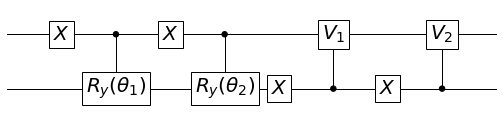

In [3]:
Ry1 = CreateOneQubitGate('Ry1', r'R_y(\theta_1)')
Ry2 = CreateOneQubitGate('Ry2', r'R_y(\theta_2)')
V1 = CreateOneQubitGate('V1', r'V_1')
V2 = CreateOneQubitGate('V2', r'V_2')

CircuitPlot(CGate(0,V2(1))*X(0)*CGate(0,V1(1))*X(0)*CGate(1,Ry2(0))*X(1)*CGate(1,Ry1(0))*X(1),2)

In [4]:
def two_element_povm(params, wire0, wire1):
    #params 

    # Controlled-RY gate controlled by first qubit in |0> state
    qml.PauliX(wires=wire0)
    qml.CRY(params[0], wires=[wire0,wire1])
    qml.PauliX(wires=wire0)
    
    # Controlled-RY gate controlled by first qubit in |1> state
    qml.CRY(params[1], wires=[wire0,wire1])
    
    # Controlled-Rotation gate (arbitrary single-qubit unitary operator) controlled by 2nd qubit in |0> state
    qml.PauliX(wires=wire1)
    qml.CRot(params[2], params[3], params[4], wires=[wire1,wire0])
    qml.PauliX(wires=wire1)

    # # Controlled-Rotation gate (arbitrary single-qubit unitary operator) controlled by 2nd qubit in |1> state
    qml.CRot(params[5], params[6], params[7], wires=[wire1,wire0])

#### Test and Drawing `two_element_povm` module

In [5]:
@qml.qnode(dev)
def povm_circuit(params):
    two_element_povm(params, 0, 1)
    return qml.expval(qml.Identity(0) @ qml.PauliZ(1))

# initial parameters
params = np.random.random([8])
povm_circuit(params)

print("Drawing a two-element POVM circuit : ")
print(povm_circuit.draw())

Drawing a two-element POVM circuit : 
 0: ──X──╭C──────────X──╭C─────────────╭Rot(0.765, 0.207, 0.659)─────╭Rot(0.102, 0.933, 0.484)──╭┤ ⟨I ⊗ Z⟩ 
 1: ─────╰RY(0.147)─────╰RY(0.441)──X──╰C─────────────────────────X──╰C─────────────────────────╰┤ ⟨I ⊗ Z⟩ 



---
## Preparing two arbitrary pure states

A pure state: $|\psi\rangle = \cos(\theta/2)|0\rangle + e^{i\phi}\sin(\theta/2)|1\rangle$, where $0\le\theta\le\pi$  and $0\le\phi\le 2\pi$.

$ U = R_z(\beta)R_y(\gamma)R_z(\delta) = \begin{bmatrix} e^{-i(\delta+\beta)/2}\cos(\gamma/2) & -e^{i(\delta-\beta)/2}\sin(\gamma/2) \\ e^{-i(\delta-\beta)/2}\sin(\gamma/2) & e^{i(\delta+\beta)/2}\cos(\gamma/2) \end{bmatrix} $

In [6]:
def state_preparation(statevector, wire0):
    theta = 2 * np.arccos(statevector[0])
    phi = np.angle(statevector[1]/np.sin(theta/2)) if not np.isclose(np.sin(theta/2), 0) else 0
    #print(theta, phi)

    qml.Rot(phi, theta, (-1)*phi, wires=wire0)

#### Test and Drawing `state_preparation` module

In [7]:
@qml.qnode(dev)
def test_initstate(test_vec):    
    state_preparation(test_vec, wire0=0)
    return qml.state()

test_vec = [1, 0]
print(test_initstate(test_vec))

print(test_initstate.draw())

[1.+0.j 0.+0.j 0.+0.j 0.+0.j]
 0: ──Rot(0, 0, 0)──┤ State 



---
## Minimum Error Discrimination

Preparation: $\{q_i,\hat{\rho}_i\}^{N}_{i=1}$ $\longleftarrow$ $\hat{\rho} = \sum_i q_i\hat{\rho}_i$. <br>

POVMs: $\{E_k\}_{k=1}^{L}$ with $\sum_{k=1}^{L} E_k = I$.

Q. Why "$N=L$" is optimal?

In general, for a state $\hat{\rho}_i$ generated in preparation, a detection event on $\hat{E}_k$ happens with probability $ p(k|i) = tr [\hat{E}_k\hat{\rho_i}] $.

$$
p_{success} = \sum_i q_i p(i|i)
$$
$$
p_{guess} = \max_{E} \sum_i q_i p(i|i)
$$
$$
p_{error} = 1 - p_{guess}
$$

For two-element POVMs $\{\hat{E}_0, \hat{E}_1\}$ on two different state prepared as $\{(q_0,\hat{\rho}_0), (q_1,\hat{\rho}_1)\}$, 
$$
p_{error} = 1 - p_{guess} = 1-\max_{\vec{\theta}}\left(q_0\text{Tr}[\hat{E}_0\hat{\rho}_0] + q_1\text{Tr}[\hat{E}_1\hat{\rho}_1] \right)
$$

---
## Classification of two different states by using POVM

$|\Psi^0_i\rangle := |\psi_0\rangle|0\rangle$ 
$\longrightarrow$ POVM $\longrightarrow$ 
$|\Psi^0_f\rangle := \left(\hat{K}_0|\psi_0\rangle\right)|0\rangle + \left(\hat{K}_1|\psi_0\rangle\right)|1\rangle$

$$
\text{Tr}[\hat{\rho}_0\hat{E}_0] = \langle\psi_0|\hat{K}^\dagger_0\hat{K}_0|\psi_0\rangle \langle 0 | 0 \rangle = \langle\psi_0|\langle 0|\hat{K}^\dagger_0\hat{K}_0|\psi_0\rangle|0\rangle\\
=\frac{1}{2}\left(\langle\psi_0|\langle 0|\hat{K}^\dagger_0\hat{K}_0|\psi_0\rangle|0\rangle + \langle\psi_0|\langle 1|\hat{K}^\dagger_1\hat{K}_1|\psi_0\rangle|1\rangle\right)\\
+\frac{1}{2}\left(\langle\psi_0|\langle 0|\hat{K}^\dagger_0\hat{K}_0|\psi_0\rangle|0\rangle - \langle\psi_0|\langle 1|\hat{K}^\dagger_1\hat{K}_1|\psi_0\rangle|1\rangle\right) \\ 
\frac{1}{2} \left(1 + \langle\Psi_f|I\otimes Z|\Psi_f\rangle\right)
$$
Similarly, $\text{Tr}[\hat{\rho}_0\hat{E}_1] = \frac{1}{2}\left(1 - \langle\Psi_f|I\otimes Z|\Psi_f\rangle\right)$.

From the minimum error discrimination, find **the optimal POVMs** for discriminating two different states:
$$
p_{error} = 1- (-1)\min_{\vec{\theta}}\left(-q_o\text{Tr}[\hat{E}_0\hat{\rho}_0] - q_1\text{Tr}[\hat{E}_1\hat{\rho}_1]\right)\\
=\min_{\vec{\theta}}\left[\frac{1}{2} - \frac{q_0}{2}\langle\Psi^0_f|I\otimes Z|\Psi^0_f\rangle + \frac{q_1}{2}\langle\Psi^1_f|I\otimes Z|\Psi^1_f\rangle\right]
$$

### Cost function : $C(\vec{\theta}) = \frac{1}{2}\left(1 - q_0\langle\Psi^0_f|I\otimes Z|\Psi^0_f\rangle + q_1\langle\Psi^1_f|I\otimes Z|\Psi^1_f\rangle\right)$

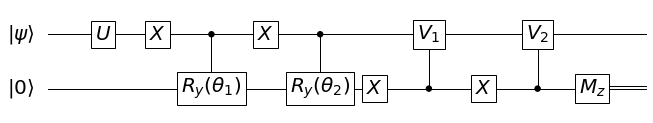

In [8]:
U = CreateOneQubitGate('U')
Ry1 = CreateOneQubitGate('Ry1', r'R_y(\theta_1)')
Ry2 = CreateOneQubitGate('Ry2', r'R_y(\theta_2)')
V1 = CreateOneQubitGate('V1', r'V_1')
V2 = CreateOneQubitGate('V2', r'V_2')

CircuitPlot(Mz(0)*CGate(0,V2(1))*X(0)*CGate(0,V1(1))*X(0)*CGate(1,Ry2(0))*X(1)*CGate(1,Ry1(0))*X(1)*U(1), 2, labels=['0','\psi'])

$ \langle\Psi_f|I\otimes Z|\Psi_f\rangle $

In [9]:
@qml.qnode(dev)
def circuit_povm_expvalIZ(init_state, params):
    state_preparation(init_state, wire0=0)

    # arbitrary rotation
    qml.Rot(params[0], params[1], params[2], wires=0)

    # two-element POVM
    two_element_povm(params[3:], 0, 1)

    return qml.expval(qml.Identity(0) @ qml.PauliZ(1))

In [10]:
params = 4 * np.pi * np.random.random([11])
params

tensor([7.79542253, 8.89677686, 6.05455665, 0.25281436, 7.41261689,
        4.19160379, 7.84321005, 2.99057206, 2.63314671, 1.04066613,
        0.35112895], requires_grad=True)

In [11]:
circuit_povm_expvalIZ(init_state=[1,0], params=params)

tensor(0.46401425, requires_grad=True)

In [41]:
def cost(x):
    psi0 = [1, 0]
    psi1 = [1/np.sqrt(2), (-1)/np.sqrt(2)]
    K0psi0 = circuit_povm_expvalIZ(psi0, x)
    K1psi1 = circuit_povm_expvalIZ(psi1, x)
    return (1/2) * (1 - (1/2)*K0psi0 + (1/2)*K1psi1)

### Optimization of POVM: solving $\min_{\vec{\theta}}C(\vec{\theta})$

In [43]:
# initialise the optimizer
opt = qml.GradientDescentOptimizer(stepsize=0.4)

# set the number of steps
steps = 120

# set the initial parameter values
params = 4 * np.pi * np.random.random([11])
print("cost(init_params) =", cost(params))

for i in range(steps):
    # update the circuit parameters
    params = opt.step(cost, params)

    if (i+1) % 5 == 0:
        print("Cost after step {:5d}: {: .7f}".format(i + 1, cost(params)))

print("Optimized rotation angles: {}".format(params))

cost(init_params) = 0.652883916256179
Cost after step     5:  0.5938230
Cost after step    10:  0.5457921
Cost after step    15:  0.5074378
Cost after step    20:  0.4717514
Cost after step    25:  0.4307519
Cost after step    30:  0.3789782
Cost after step    35:  0.3180960
Cost after step    40:  0.2586086
Cost after step    45:  0.2119580
Cost after step    50:  0.1816660
Cost after step    55:  0.1644183
Cost after step    60:  0.1553506
Cost after step    65:  0.1507898
Cost after step    70:  0.1485485
Cost after step    75:  0.1474598
Cost after step    80:  0.1469341
Cost after step    85:  0.1466809
Cost after step    90:  0.1465592
Cost after step    95:  0.1465007
Cost after step   100:  0.1464726
Cost after step   105:  0.1464591
Cost after step   110:  0.1464526
Cost after step   115:  0.1464495
Cost after step   120:  0.1464480
Optimized rotation angles: [12.56515074  2.356198    0.05088934  3.14199409 12.56262968  1.02152461
  8.40963872  9.51901992  2.46702336  4.921076

In [40]:
print("Drawing a circuit of povm_expvalIZ : ")
print(circuit_povm_expvalIZ.draw())

Drawing a circuit of povm_expvalIZ : 
 0: ──Rot(0, 3.14, -0)──Rot(5.33, 9.42, 5.28)──X──╭C─────────X──╭C────────────╭Rot(11.6, 8.4, 0.616)─────╭Rot(10.3, 10.1, 10.5)──╭┤ ⟨I ⊗ Z⟩ 
 1: ──────────────────────────────────────────────╰RY(9.42)─────╰RY(6.28)──X──╰C──────────────────────X──╰C──────────────────────╰┤ ⟨I ⊗ Z⟩ 



---
## Calculating Kraus Operators $\{K_i\}$ and POVMs $\{\hat{E}_i\}$.

### Arbitrary rotation of the single qubit
### $$ U = R_z(\beta)R_y(\gamma)R_z(\delta) = \begin{bmatrix} e^{-i(\delta+\beta)/2}\cos(\gamma/2) & -e^{i(\delta-\beta)/2}\sin(\gamma/2) \\ e^{-i(\delta-\beta)/2}\sin(\gamma/2) & e^{i(\delta+\beta)/2}\cos(\gamma/2) \end{bmatrix}$$

### Y-Rotation of the single qubit
### $$ R_y(\phi) = e^{-i\phi\sigma_y/2} = \begin{bmatrix} \cos\phi/2 & -\sin\phi/2 \\ \sin\phi/2 & \cos\phi/2 \end{bmatrix} $$

In [44]:
def unitaries_in_povm(params):
    U = qml.Rot(params[0], params[1], params[2], wires=2).matrix
    Ry0 = qml.RY(params[3], wires=2).matrix
    Ry1 = qml.RY(params[4], wires=2).matrix
    V0 = qml.Rot(params[5], params[6], params[7], wires=2).matrix
    V1 = qml.Rot(params[8], params[9], params[10], wires=2).matrix

    return U, Ry0, Ry1, V0, V1

U, Ry0, Ry1, V0, V1 = unitaries_in_povm(params)

$$
\hat{K}_0 = V_0D_0U \\
\hat{K}_1 = V_1D_1U 
$$

In [45]:
def kraus_op(params):
    U, _, _, V0, V1 = unitaries_in_povm(params)
    D0 = np.diag([np.cos(params[3]/2), np.cos(params[4]/2)])
    D1 = np.diag([np.sin(params[3]/2), np.sin(params[4]/2)])
    K0 = np.dot(np.dot(V0, D0), U)
    K1 = np.dot(np.dot(V1, D1), U)

    return K0, K1

In [46]:
K0, K1 = kraus_op(params)

print("K0 =", K0)
print("K1 =", K1)

K0 = [[-0.37974791+0.71254552j -0.15699402+0.29524811j]
 [-0.24760192+0.37458691j -0.10228091+0.15545076j]]
K1 = [[-0.29769065-0.0172993j   0.71614317+0.04253463j]
 [-0.20219185-0.12902643j  0.49230685+0.31067482j]]


$ \hat{K}^\dagger_0\hat{K}_0 + \hat{K}^\dagger_1\hat{K}_1 = I$

In [47]:
E0 = np.dot(K0.conj().T, K0) 
E1 = np.dot(K1.conj().T, K1)
print("E0 =", E0)
print("E1 =", E1)
print("E0 + E1 =", E0 + E1)

E0 = [[0.85355165+0.j         0.35355064-0.00043129j]
 [0.35355064+0.00043129j 0.14644489+0.j        ]]
E1 = [[ 0.14644835+0.j         -0.35355064+0.00043129j]
 [-0.35355064-0.00043129j  0.85355511+0.j        ]]
E0 + E1 = [[1.00000000e+00+0.00000000e+00j 5.55111512e-17-5.55111512e-17j]
 [5.55111512e-17+5.55111512e-17j 1.00000000e+00+0.00000000e+00j]]


$ \langle \psi_0 |\hat{K}^\dagger_0\hat{K}_0|\psi_0\rangle$

In [48]:
res = np.dot(K0, np.array([1,0]))
np.dot(res.conj(),res)

(0.8535516507418781+0j)

$ \langle \psi_1 |\hat{K}^\dagger_1\hat{K}_1|\psi_1\rangle$

In [49]:
res = np.dot(K1, np.array([1/np.sqrt(2),-1/np.sqrt(2)]))
np.dot(res.conj(),res)

(0.8535523649729821+0j)

---
## Analytical approach

Note <br>
$\text{Tr}[\hat{\rho}_0\hat{E}_0] + \text{Tr}[\hat{\rho}_1\hat{E}_1]$ <br>
$=\text{Tr}[q_1\hat{\rho}_1 + \hat{E}_0(q_0\hat{\rho}_0-q_1\hat{\rho}_1)]$ <br>
$=\text{Tr}[q_0\hat{\rho}_0 - \hat{E}_0(q_0\hat{\rho}_0-q_1\hat{\rho}_1)]$ <br>
$=\frac{1}{2} + \frac{1}{2}\text{Tr}[(\hat{E}_0-\hat{E}_1)\Lambda] $,
where $\Lambda := q_0\hat{\rho}_0-q_1\hat{\rho}_1$.

$$
\min_E C(\vec{\theta}) = \min_E \left(1 - \text{Tr}[\hat{\rho}_0\hat{E}_0] - \text{Tr}[\hat{\rho}_1\hat{E}_1]\right) \\
= \min_E\left(1 - \frac{1}{2} - \frac{1}{2}\text{Tr}[(\hat{E}_0-\hat{E}_1)\Lambda]\right)\\
= \frac{1}{2} - \frac{1}{2}\max_{E} \text{Tr}[(\hat{E}_0-\hat{E}_1)\Lambda] = \frac{1}{2} - \frac{1}{2}\text{Tr}|\Lambda|
$$

***Spectral Decomposition***: $\Lambda = \lambda_+|\lambda_+\rangle\langle\lambda_+| + \lambda_-|\lambda_-\rangle\langle\lambda_-|$ <br>
<br>
$\hat{E}_0-\hat{E}_1 = |\lambda_+\rangle\langle\lambda_+| - |\lambda_-\rangle\langle\lambda_-|$ gives rise to the maximum.

In [50]:
def spectral_decomp(q1, q2, rho1, rho2):
    w, v = np.linalg.eig(q1*rho1 - q2*rho2)

    return w, v

In [51]:
rho1, rho2 = np.array([[1, 0], [0, 0]]), np.array([[1/2, -1/2], [-1/2, 1/2]])

q1, q2 = 1/2, 1/2
#rho1 = np.array([[1/2, 1/2], [1/2, 1/2]])
#rho2 = np.array([[0, 0], [0, 1]])

w, v = spectral_decomp(q1, q2, rho1, rho2)

In [52]:
print("min of cost function: ", (1 - np.sum(np.abs(w)))/2)
print("E0 =", np.tensordot(v[:,0],v[:,0], axes=0))
print("E1 =", np.tensordot(v[:,1],v[:,1], axes=0))

min of cost function:  0.14644660940672627
E0 = [[0.85355339 0.35355339]
 [0.35355339 0.14644661]]
E1 = [[ 0.14644661 -0.35355339]
 [-0.35355339  0.85355339]]


---
## To Do

Write and Read further about optimization...
1. First of all!!!, [Measurement optimization](https://pennylane.ai/qml/demos/tutorial_measurement_optimize.html) <br>
[Plugins and Hybrid computation](https://pennylane.ai/qml/demos/tutorial_plugins_hybrid.html) <br>
[Ensemble classification with Forest and Qiskit devices](https://pennylane.ai/qml/demos/tutorial_ensemble_multi_qpu.html) <br>
[Forum: Measurements and output state probabilities in a single circuit](https://discuss.pennylane.ai/t/measurements-and-output-state-probabilities-in-a-single-circuit/1089/7) <br>
<br>
2. [Quantum gradients](https://pennylane.ai/qml/glossary/quantum_gradient.html) <br>
[Quantum Differentiable Programming](https://pennylane.ai/qml/glossary/quantum_differentiable_programming.html) <br>
[Gradients and training](https://pennylane.readthedocs.io/en/stable/introduction/interfaces.html) <br>
<br>
3. [Noisy circuits](https://pennylane.ai/qml/demos/tutorial_noisy_circuits.html), [Ref] Johannes Jakob Meyer, Johannes Borregaard, and Jens Eisert, “A variational toolbox for quantum multi-parameter estimation.” [arXiv:2006.06303 (2020)](https://arxiv.org/abs/2006.06303). <br>
[Optimizing noisy circuits with Cirq](https://pennylane.ai/qml/demos/tutorial_noisy_circuit_optimization.html) <br>
* [How to simulate noise with PennyLane](https://pennylane.ai/blog/2021/05/how-to-simulate-noise-with-pennylane/) <br>
<br>
4. Quantum Volume in [pennylane](https://pennylane.ai/qml/demos/quantum_volume.html) or in [qiskit](https://qiskit.org/documentation/tutorials/noise/5_quantum_volume.html)<br>



Analytic Analysis <br>
1. Helstrom measurement (Helstrom bound)
2. [Wiki POVM, an example: unambiguous quantum state discrimination](https://en.wikipedia.org/wiki/POVM)

---

Probability로 사용하기

In [111]:
dev = qml.device("default.qubit", wires=2, shots=8000)

@qml.qnode(dev)
def circuit():
    qml.Hadamard(wires=0)
    return qml.probs(wires=[0])

In [113]:
circuit()

tensor([0.49125, 0.50875], requires_grad=False)